In [ ]:
import numpy as np
from scipy import signal

def matlab_form(z, p, k):
    """
    Konwertuje zeros, poles, gain do formatu SOS jak w Matlabie.
    
    Parameters:
    z : array - zeros
    p : array - poles  
    k : float - gain
    
    Returns:
    sos_var : array - sekcje drugiego rzędu w formacie Matlaba
    g : float - gain
    """
    
    # Konwersja do SOS
    sos = signal.zpk2sos(z, p, k)
    
    # Wyciągnij gain z pierwszej sekcji
    g = sos[0, 0]
    sos_normalized = sos.copy()
    sos_normalized[0, :3] = sos_normalized[0, :3] / g
    
    # Sortowanie według częstotliwości rezonansowej (jak Matlab)
    def resonant_freq(sos_section):
        a1, a2 = sos_section[4], sos_section[5]
        return np.abs(np.angle(np.roots([1, a1, a2]))).min()
    
    freq_order = np.argsort([resonant_freq(section) for section in sos_normalized])[::-1]
    sos_var = sos_normalized[freq_order]
    
    return sos_var, g



In [1]:
import numpy as np
from scipy import signal

def matlab_form(z, p, k):
    """
    Konwertuje zeros, poles, gain do formatu SOS jak w Matlabie.
    """
    
    def cplxpair(inp):
        """Sortuje liczby zespolone"""
        thresh = 100 * np.finfo(float).eps
        inp_cp = inp[np.abs(np.imag(inp)) > thresh]  # zespolone
        inp_re = inp[np.abs(np.imag(inp)) <= thresh]  # rzeczywiste
        
        # Sortuj zespolone według Re, potem Im
        if len(inp_cp) > 0:
            idx = np.lexsort((np.imag(inp_cp), np.real(inp_cp)))
            inp_cp = inp_cp[idx]
        
        return np.concatenate([inp_cp, np.real(inp_re)])
    
    def cplxreal(z_inp):
        """Dzieli na pary zespolone i rzeczywiste"""
        if len(z_inp) == 0:
            return [], []
        
        zcp = cplxpair(z_inp)
        thresh = 100 * np.finfo(float).eps
        
        # Znajdź ile jest rzeczywistych na końcu
        nzrsec = 0
        for i in range(len(zcp)-1, -1, -1):
            if np.abs(np.imag(zcp[i])) > thresh:
                break
            nzrsec += 1
        
        nzsect2 = len(zcp) - nzrsec
        
        # Wyciągnij zespolone (co drugi, zaczynając od 2.)
        if nzsect2 > 0:
            zc = zcp[1:nzsect2:2]  # co drugi, zaczynając od indeksu 1
        else:
            zc = []
            
        # Wyciągnij rzeczywiste
        if nzrsec > 0:
            zr = np.real(zcp[nzsect2:])
        else:
            zr = []
            
        return zc, zr
    
    # Podziel zera i bieguny
    zc, zr = cplxreal(z)
    pc, pr = cplxreal(p)
    
    nzc, nzr = len(zc), len(zr)
    npc, npr = len(pc), len(pr)
    
    # Sparuj rzeczywiste zera
    if nzr % 2 == 1:
        zr = np.append(zr, 0)
        nzr += 1
    
    # Sparuj rzeczywiste bieguny  
    if npr % 2 == 1:
        pr = np.append(pr, 0)
        npr += 1
    
    nsecs = max(nzc + nzr//2, npc + npr//2)
    
    # Utwórz macierz SOS
    sos = np.ones((nsecs, 6))
    sos[:, 3] = 1  # a0 = 1
    
    # Wypełnij sekcje
    for i in range(nsecs):
        # Zera
        if i < nzc:  # zespolone zera
            sos[i, 1] = -2 * np.real(zc[i])
            sos[i, 2] = np.abs(zc[i])**2
        elif i < nzc + nzr//2:  # rzeczywiste zera
            idx = (i - nzc) * 2
            sos[i, 1] = -(zr[idx] + zr[idx+1])
            sos[i, 2] = zr[idx] * zr[idx+1]
        
        # Bieguny
        if i < npc:  # zespolone bieguny
            sos[i, 4] = -2 * np.real(pc[i])
            sos[i, 5] = np.abs(pc[i])**2
        elif i < npc + npr//2:  # rzeczywiste bieguny
            idx = (i - npc) * 2
            sos[i, 4] = -(pr[idx] + pr[idx+1])
            sos[i, 5] = pr[idx] * pr[idx+1]
    
    return sos, k

zapiski z Matlaba
```
[b, a] = butter(4, [0.2, 0.6]);
[z,p,k] = tf2zp(b, a)
[sos_var,g] = zp2sos(z, p, k)
sos_var =
    1.0000000   2.0001266   1.0001266   1.0000000   0.4575326   0.6245384
    1.0000000   1.9998734   0.9998734   1.0000000  -0.0073608   0.1956041
    1.0000000  -2.0000000   1.0000000   1.0000000  -0.8822287   0.3301957
    1.0000000  -2.0000000   1.0000000   1.0000000  -1.3945409   0.7466724
g =  0.046583
```

In [28]:
b, a = signal.butter(4, [0.2, 0.6], btype='band')
z, p, k = signal.tf2zpk(b, a)

sos_var, g = matlab_form(z, p, k)
print("sos_var =")
print(sos_var)
print(f"g = {g}")



sos_var =
[[ 1.          2.00012445  1.00012446  1.          0.45753265  0.62453836]
 [ 1.          1.99987555  0.99987555  1.         -0.00736084  0.19560414]
 [ 1.         -2.          1.          1.         -0.88222871  0.33019575]
 [ 1.         -2.          1.          1.         -1.39454092  0.74667242]]
g = 0.04658290663644366


```
# [z,p,g]=butter(4/2, [1.8, 30]/(fs/2));
# [sos_var,g] = zp2sos(z, p, k)
# sos_var =
#     1.00000   2.00000   1.00000   1.00000  -1.76226   0.79070
#     1.00000  -2.00000   1.00000   1.00000  -1.98425   0.98439
# g =  0.0041592
```

In [18]:
fs = 1000
z, p, k = signal.butter(2, [1.8/(fs/2), 30/(fs/2)], btype='band', output='zpk')
sos = signal.zpk2sos(z, p, k)
sos_var, g = matlab_form(z, p, k)

print("sos_var =")
print(sos_var)
print(f"g = {g}")



sos_var =
[[ 1.         -2.          1.          1.         -1.76225856  0.79069944]
 [ 1.          2.          1.          1.         -1.98424646  0.98438812]]
g = 0.0069606524208165035


```
tf = butter(4, 0.6, type = "low")
tf2sos(tf)
# [z,p,g]=butter(4, 0.6);
# [sos_var,g] = zp2sos(z, p, k)
# sos_var =
#     1.000000   2.000000   1.000000   1.000000   0.453120   0.466326
#     1.000000   2.000000   1.000000   1.000000   0.328976   0.064588
# g =  0.046583
```

In [35]:
z, p, k = signal.butter(4, 0.6, btype='low', output='zpk')
sos = signal.zpk2sos(z, p, k)
sos_var, g = matlab_form(z, p, k)

print("sos_var =")
print(sos_var)
print(f"g = {g}")

sos_var =
[[1.         2.         1.         1.         0.45311952 0.46632557]
 [1.         2.         1.         1.         0.32897568 0.06458765]]
g = 0.16717926860848992


```
tf = butter(4, 10 / (fs/2), type = "low")
tf2sos(tf)
# [z,p,g]=butter(4,  10 / (fs/2), type = "low");
# [sos_var,g] = zp2sos(z, p, k)

# { {1,2,1}, {1,-1.8866095826215084000,0.89033973628402607000}, 8.9848614639706479000e-007,  1  },
# { {1,2,1}, {1,-1.9492159580258410000,0.95306989532789022000}, 1, 1 }  }

```

In [11]:
fs = 1000
z, p, k = signal.butter(4, 10 / (fs/2), btype='low', output='zpk')
sos = signal.zpk2sos(z, p, k)
sos_var, g = matlab_form(z, p, k)

print("sos_var =")
print(sos_var)
print(f"g = {g}")

sos_var =
[[ 1.          2.          1.          1.         -1.88660958  0.89033974]
 [ 1.          2.          1.          1.         -1.94921596  0.9530699 ]]
g = 8.984861463970648e-07


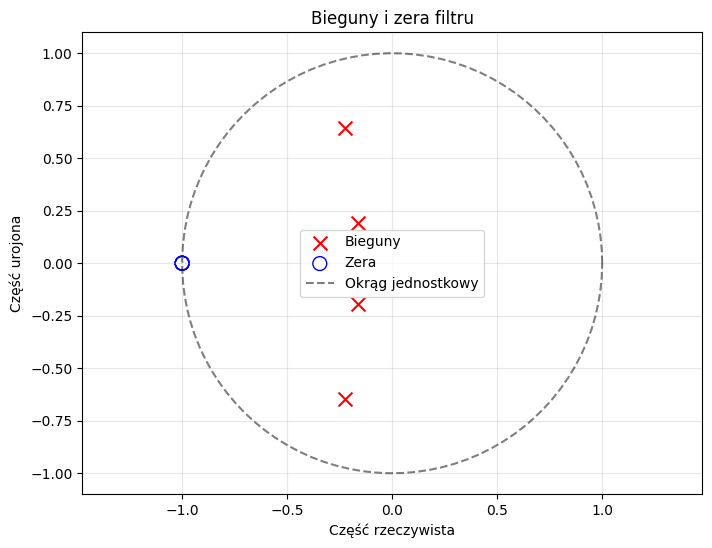

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Dla biegunów i zer
plt.figure(figsize=(8, 6))
plt.scatter(np.real(p), np.imag(p), marker='x', s=100, color='red', label='Bieguny')
plt.scatter(np.real(z), np.imag(z), marker='o', s=100, facecolors='none', edgecolors='blue', label='Zera')

# Okrąg jednostkowy
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Okrąg jednostkowy')

plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlabel('Część rzeczywista')
plt.ylabel('Część urojona')
plt.legend()
plt.title('Bieguny i zera filtru')
plt.show()


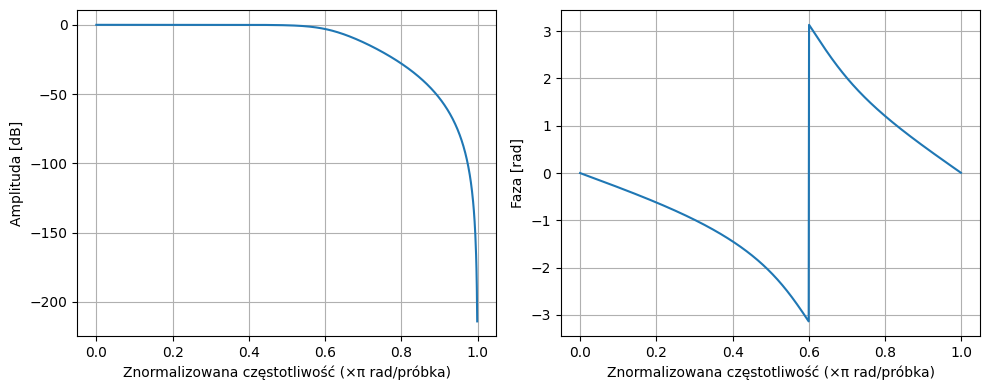

In [37]:
# Charakterystyka częstotliwościowa
w, h = signal.freqz_zpk(z, p, k, worN=1024)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(w/np.pi, 20*np.log10(np.abs(h)))
plt.xlabel('Znormalizowana częstotliwość (×π rad/próbka)')
plt.ylabel('Amplituda [dB]')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(w/np.pi, np.angle(h))
plt.xlabel('Znormalizowana częstotliwość (×π rad/próbka)')
plt.ylabel('Faza [rad]')
plt.grid(True)
plt.tight_layout()
plt.show()

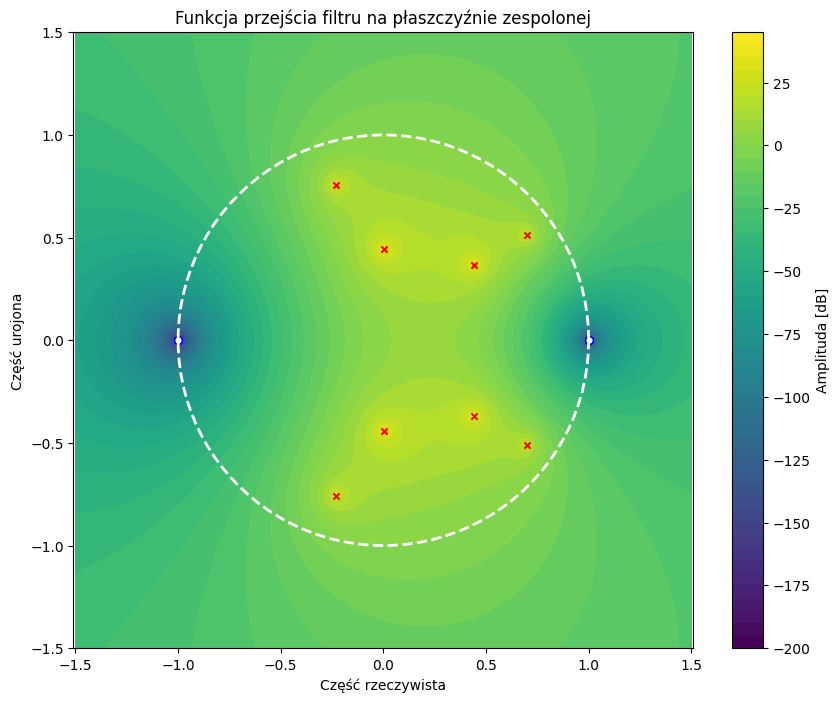

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Siatka na płaszczyźnie zespolonej
x = np.linspace(-1.5, 1.5, 300)
y = np.linspace(-1.5, 1.5, 300)
X, Y = np.meshgrid(x, y)
Z = X + 1j*Y

# Oblicz funkcję przejścia H(z) = k * prod(z-zi) / prod(z-pi)
H = np.ones_like(Z) * k

# Licznik - iloczyn (z - zi)
for zero in z:
    H *= (Z - zero)

# Mianownik - iloczyn (z - pi)  
for pole in p:
    H /= (Z - pole)

# Logarytm amplitudy (w dB)
H_mag_db = 20 * np.log10(np.abs(H) + 1e-10)  # +epsilon żeby uniknąć log(0)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, H_mag_db, levels=50, cmap='viridis')
plt.colorbar(label='Amplituda [dB]')

# Dodaj bieguny i zera
plt.scatter(np.real(p), np.imag(p), marker='x', s=20, color='red', label='Bieguny')
plt.scatter(np.real(z), np.imag(z), marker='o', s=30, facecolors='white', edgecolors='blue', label='Zera')

# Okrąg jednostkowy
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'w--', linewidth=2, label='Okrąg jednostkowy')

plt.xlabel('Część rzeczywista')
plt.ylabel('Część urojona')
plt.title('Funkcja przejścia filtru na płaszczyźnie zespolonej')
# plt.legend()
plt.axis('equal')
plt.show()